In [1]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

## Model Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
params = {'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.9,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 8,
 'missing': None,
 'monotone_constraints': None,
 'n_estimators': 12,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 27,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None,
 'nthread': 4,
 'seed': 27,
 'tree_method': 'hist'}

In [3]:
df = pd.read_csv("df_cleaned.csv").iloc[:,1:]

In [4]:
df.groupby("label").size()

label
APPROVED    356
REJECTED     85
dtype: int64

In [5]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [6]:
X = df.iloc[:, 1:8]

## Train/Test Split

In [7]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
clf = XGBClassifier(**params)
clf = clf.fit(X_train, y_train)

In [10]:
y_pred = clf.predict(X_test)

In [11]:
y_pred_proba = clf.predict_proba(X_test)

In [12]:
np.round(accuracy_score(y_test, y_pred), 2)

0.89

In [13]:
y_test.value_counts()

0    111
1     35
Name: label, dtype: int64

In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(107, 4, 12, 23)

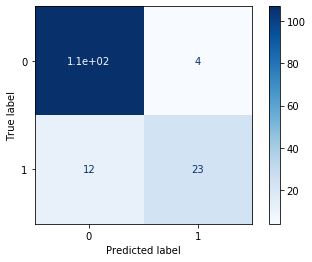

In [15]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

In [17]:
auc_score = auc(fpr, tpr)

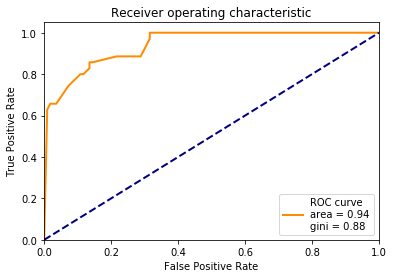

In [18]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve \narea = %0.2f\ngini = %0.2f' % (auc_score, 2*auc_score-1))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Bootstrapped

In [19]:
accuracy_list = []
auc_list = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    clf = XGBClassifier()
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    
    accuracy_list.append(accuracy)
    auc_list.append(auc_score)
    print("Iteration %s: AUC:%s, Accuracy:%s" % (i, auc_score, accuracy))

Iteration 0: AUC:0.9517241379310345, Accuracy:0.8904109589041096
Iteration 1: AUC:0.8840647370059135, Accuracy:0.910958904109589
Iteration 2: AUC:0.9279102384291725, Accuracy:0.8835616438356164
Iteration 3: AUC:0.8932461873638344, Accuracy:0.910958904109589
Iteration 4: AUC:0.9413461538461538, Accuracy:0.910958904109589
Iteration 5: AUC:0.9498968464485706, Accuracy:0.9041095890410958
Iteration 6: AUC:0.9313725490196078, Accuracy:0.910958904109589
Iteration 7: AUC:0.8981633771929824, Accuracy:0.8835616438356164
Iteration 8: AUC:0.914497578692494, Accuracy:0.8767123287671232
Iteration 9: AUC:0.9106984969053935, Accuracy:0.8767123287671232
Iteration 10: AUC:0.9085950413223141, Accuracy:0.8972602739726028
Iteration 11: AUC:0.917816091954023, Accuracy:0.8904109589041096
Iteration 12: AUC:0.9164095371669004, Accuracy:0.8972602739726028
Iteration 13: AUC:0.9343390804597701, Accuracy:0.9041095890410958
Iteration 14: AUC:0.9229295608605953, Accuracy:0.8972602739726028
Iteration 15: AUC:0.917221

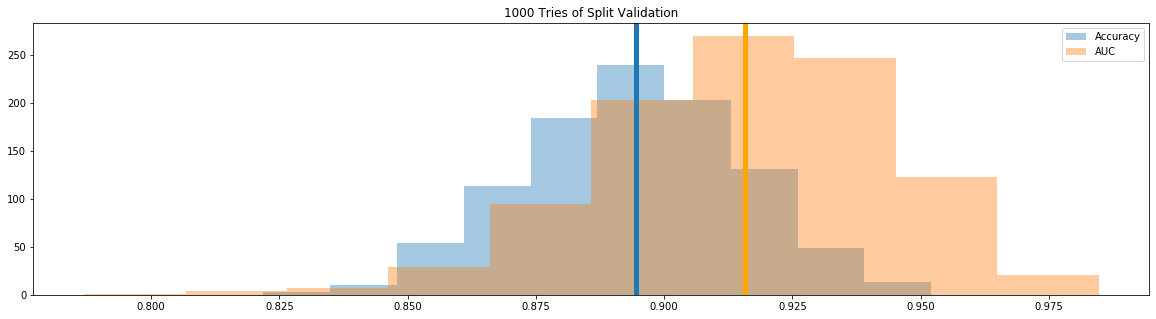

Accuracy mean: 0.89
AUC mean: 0.92


In [20]:
plt.figure(figsize=(20,5))
plt.title("1000 Tries of Split Validation")
sns.distplot(accuracy_list, bins=10, label = 'Accuracy', kde=False)
sns.distplot(auc_list, bins=10, label = 'AUC', kde=False)
plt.axvline(x=pd.Series(accuracy_list).mean(), lw=5)
plt.axvline(x=pd.Series(auc_list).mean(), lw=5, color='orange')
plt.legend()
plt.show()
print("Accuracy mean: %0.2f" % pd.Series(accuracy_list).mean())
print("AUC mean: %0.2f" % pd.Series(auc_list).mean())

## Model Comparison

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
## Initiate models
models = []
models.append(('K-Nearest Neighbour', KNeighborsClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('XGBoost Classifier', XGBClassifier()))

In [23]:
## Results
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    ## AUC Scoring
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    print('%s: \nMean %f, STD %f'%(name, cv_results.mean(), cv_results.std()))

K-Nearest Neighbour: 
Mean 0.834583, STD 0.129110
Decision Tree Classifier: 
Mean 0.890817, STD 0.094397
Gaussian Naive Bayes: 
Mean 0.912567, STD 0.077335
XGBoost Classifier: 
Mean 0.921600, STD 0.073362


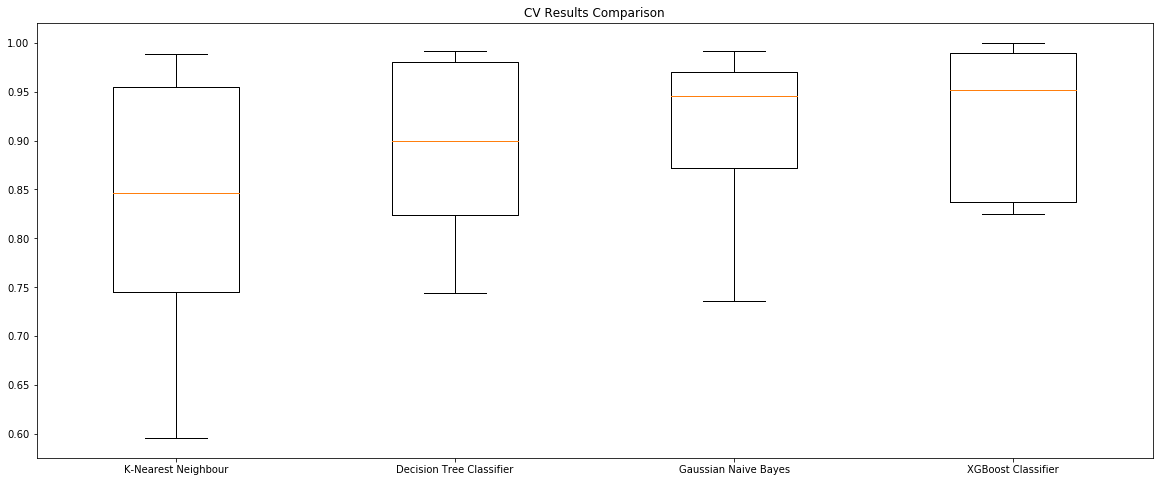

In [24]:
## Results Distribution
plt.figure(figsize=(20,8))
plt.boxplot(results, labels=names)
plt.title('CV Results Comparison')
plt.show()

## Dump To Pickle

In [25]:
clf = XGBClassifier(**params)
clf = clf.fit(X, y)
# pickle.dump(clf, open('../models/final_prediction.pickle', 'wb'))

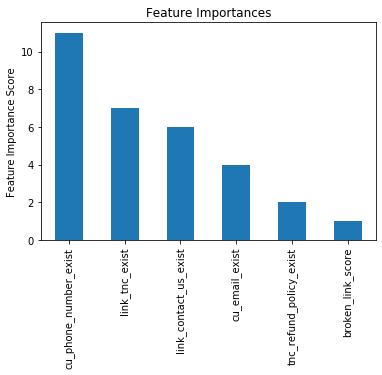

In [26]:
feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()